In [7]:
# Data from - https://www.clips.uantwerpen.be/conll2000/chunking/

In [38]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import classification_report

In [12]:
def prepare_data(file_path):
    sentences = []
    tags = []
    with open(file_path, "r", encoding="utf-8") as f:
        sentence = []
        pos_tags = []
        for line in f:
            line = line.strip()
            if line == "":  # Sentence boundary
                if sentence:
                    sentences.append(sentence)
                    tags.append(pos_tags)
                    sentence = []
                    pos_tags = []
            else:
                parts = line.split()
                if len(parts) >= 2:  # Ensure the line has at least word and POS tag
                    word, pos_tag = parts[0], parts[1]
                    sentence.append(word)
                    pos_tags.append(pos_tag)
        if sentence:
            sentences.append(sentence)
            tags.append(pos_tags)
    return sentences, tags

In [13]:
file_path = "./data/train.txt"
sentences, pos_tags = prepare_data(file_path)

In [14]:
word_vocab = {word: idx for idx, word in enumerate(set(w for s in sentences for w in s), start=1)}
word_vocab["<PAD>"] = 0  # For padding
word_vocab["<UNK>"] = len(word_vocab)  # For unknown words

tag_vocab = {tag: idx for idx, tag in enumerate(set(t for ts in pos_tags for t in ts))}
idx2tag = {tag_vocab[tag] : tag for tag in tag_vocab.keys()}

In [15]:
len(word_vocab),len(tag_vocab)

(19124, 44)

In [16]:
def encode_data(sentences, tags, word_vocab, tag_vocab):
    encoded_sentences = [[word_vocab.get(w, word_vocab["<UNK>"]) for w in s] for s in sentences]
    encoded_tags = [[tag_vocab[t] for t in ts] for ts in tags]
    return encoded_sentences, encoded_tags

In [18]:
test_file_path = "./data/test.txt"
t_sentences, t_pos_tags = prepare_data(test_file_path)

In [19]:
X_train, y_train = encode_data(sentences, pos_tags, word_vocab, tag_vocab)
X_test, y_test = encode_data(t_sentences,t_pos_tags,word_vocab,tag_vocab)

In [21]:
len(X_train),len(X_test)

(8936, 2012)

In [23]:
def pad_sequences(data, pad_value):
    return pad_sequence([torch.tensor(seq) for seq in data], batch_first=True, padding_value=pad_value)

In [24]:
X_train = pad_sequences(X_train, word_vocab["<PAD>"])
y_train = pad_sequences(y_train, -1)  # Use -1 as the padding value for loss functions

In [25]:
X_test = pad_sequences(X_test,word_vocab["<PAD>"])
y_test = pad_sequences(y_test,-1)

In [27]:
X_train.shape,X_test.shape

(torch.Size([8936, 78]), torch.Size([2012, 70]))

In [28]:
y_train.shape,y_test.shape

(torch.Size([8936, 78]), torch.Size([2012, 70]))

In [30]:
class NERData(Dataset):
    def __init__(self,X,y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, index):
        return self.X[index],self.y[index]
        

In [31]:
traindata = NERData(X_train,y_train)
testdata = NERData(X_test,y_test)

In [32]:
train_loader = DataLoader(traindata,batch_size = 32, shuffle= True)
test_loader = DataLoader(testdata,batch_size=32)

In [34]:
class NERModel(nn.Module):
    def __init__(self, vocab_size, tagset_size, embedding_dim=100, hidden_dim=128):
        super(NERModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, tagset_size)

    def forward(self, x):
        x = self.embedding(x) 
        lstm_out, _ = self.lstm(x)
        logits = self.fc(lstm_out)
        return logits

In [35]:
model = NERModel(vocab_size=len(word_vocab),tagset_size=len(tag_vocab))
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)
criterion = nn.CrossEntropyLoss(ignore_index=-1) # -1 to ignore the padded vals
losses = []

/home/satya-tt0492/anaconda3/envs/ex5/lib/python3.9/site-packages/onnxscript/converter.py:820: FutureWarning: 'onnxscript.values.Op.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()
/home/satya-tt0492/anaconda3/envs/ex5/lib/python3.9/site-packages/onnxscript/converter.py:820: FutureWarning: 'onnxscript.values.OnnxFunction.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()


In [37]:
for epoch in range(50):
    model.train()
    total_loss = 0
    for x,y in train_loader:
        optimizer.zero_grad()
        outputs = model(x)
        outputs = outputs.view(-1,outputs.shape[-1])
        y = y.view(-1)

        loss = criterion(outputs,y)
        loss.backward()

        optimizer.step()
        total_loss += loss.item()
    losses.append(total_loss)
    print(f"Epoch {epoch + 1}, Loss: {total_loss:.4f}")

Epoch 1, Loss: 445.9265
Epoch 2, Loss: 192.0531
Epoch 3, Loss: 127.3796
Epoch 4, Loss: 92.3088
Epoch 5, Loss: 69.6354
Epoch 6, Loss: 53.5135
Epoch 7, Loss: 41.5536
Epoch 8, Loss: 32.3723
Epoch 9, Loss: 25.1366
Epoch 10, Loss: 19.5172
Epoch 11, Loss: 15.1867
Epoch 12, Loss: 11.7466
Epoch 13, Loss: 9.1603
Epoch 14, Loss: 7.1363
Epoch 15, Loss: 5.5492
Epoch 16, Loss: 4.3617
Epoch 17, Loss: 3.4498
Epoch 18, Loss: 2.7384
Epoch 19, Loss: 2.2099
Epoch 20, Loss: 1.8077
Epoch 21, Loss: 1.5518
Epoch 22, Loss: 1.2983
Epoch 23, Loss: 1.1570
Epoch 24, Loss: 1.0766
Epoch 25, Loss: 0.9881
Epoch 26, Loss: 0.8778
Epoch 27, Loss: 0.8449
Epoch 28, Loss: 0.7943
Epoch 29, Loss: 0.7641
Epoch 30, Loss: 0.9076
Epoch 31, Loss: 1.2810
Epoch 32, Loss: 0.9126
Epoch 33, Loss: 0.7210
Epoch 34, Loss: 0.6331
Epoch 35, Loss: 0.6078
Epoch 36, Loss: 0.5897
Epoch 37, Loss: 0.5934
Epoch 38, Loss: 0.5787
Epoch 39, Loss: 0.5818
Epoch 40, Loss: 0.5504
Epoch 41, Loss: 0.5498
Epoch 42, Loss: 0.5424
Epoch 43, Loss: 0.5543
Epoch

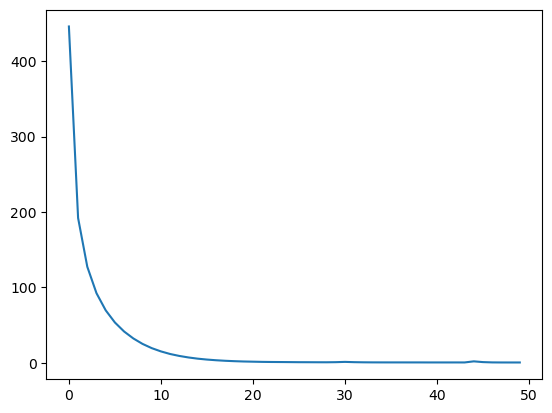

In [39]:
plt.plot(losses)

In [40]:
model.eval()
all_preds, all_labels = [],[]
with torch.no_grad():
    for x,y in test_loader:
        outputs = model(x)
        preds = torch.argmax(outputs,dim = -1)

        all_preds.extend(preds.view(-1).tolist())
        all_labels.extend(y.view(-1).tolist())

In [41]:
valid_indices = [i for i, label in enumerate(all_labels) if label != -1]
filtered_labels = [all_labels[i] for i in valid_indices]
filtered_preds = [all_preds[i] for i in valid_indices]

print(f"Filtered labels length: {len(filtered_labels)}")
print(f"Filtered preds length: {len(filtered_preds)}")

Filtered labels length: 47377
Filtered preds length: 47377


In [42]:
print(classification_report(filtered_labels,filtered_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       814
           1       0.92      0.90      0.91       913
           2       0.87      0.94      0.90      1269
           3       1.00      1.00      1.00      1178
           4       0.85      0.86      0.86       202
           5       0.79      0.91      0.85      3034
           6       1.00      0.99      1.00       110
           7       0.93      0.90      0.92      6642
           8       1.00      1.00      1.00        77
           9       0.92      0.85      0.88      4806
          10       0.82      0.55      0.65       130
          11       1.00      0.99      0.99       470
          12       1.00      0.99      0.99        93
          13       1.00      1.00      1.00       238
          14       0.77      0.76      0.76       202
          15       1.00      1.00      1.00         4
          16       1.00      1.00      1.00        11
          17       0.80    

Accuracy - 93%

In [43]:
sent = "The quick fox jump over the dog"
sent = sent.split()
inp = torch.tensor([word_vocab[word] for word in sent])
outputs = model(inp)

In [44]:
output = torch.argmax(outputs,dim=-1).view(-1)

In [45]:
output = output.tolist()
tags = [idx2tag[idx] for idx in output]

In [46]:
tags

['DT', 'JJ', 'NN', 'NN', 'IN', 'DT', 'NN']